## Building load forecasting: Hospital in SF

We can train a forecaster on another commom energy problem. In this, case we are training a 1-step ahead forecaster to predict the electricity consumption of a building.

The dataset contains one year of hourly observations.
The training will occur on 11 months of the data, reserving the last month for evaluation.

In [1]:
!pip3 install pandas -q
!pip3 install neuralprophet -q
!pip3 install livelossplot -q
!pip3 install hyperopt -q

In [2]:
import urllib
import os
import pickle
import pandas as pd
from neuralprophet import NeuralProphet
from zipfile import ZipFile
import requests
from hyperopt import hp, fmin, tpe, space_eval

## Data Collection & Preparation
Downloading and loading the data into Pandas Dataframes, then creating a 'ds' and 'y' for Prophet to fit.

In [3]:
#download the dataset and save it
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00501/PRSA2017_Data_20130301-20170228.zip"
r = requests.get(url, allow_redirects=True)

open('data.zip', 'wb').write(r.content)

7959991

In [4]:
zip_file = ZipFile('data.zip')
files = zip_file.infolist()

#read one city into a data frame
df_a = pd.read_csv(zip_file.open(files[8].filename))

#composite dataframe of all the cities in the dataset
df = pd.read_csv(zip_file.open(files[1].filename))
for i in files[2:]:
    df = pd.concat([df, pd.read_csv(zip_file.open(i.filename))])

In [5]:
df_a.head()

,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
0,1,2013,3,1,0,5.0,14.0,4.0,12.0,200.0,85.0,-0.5,1024.5,-21.4,0.0,NNW,5.7,Nongzhanguan
1,2,2013,3,1,1,8.0,12.0,6.0,14.0,200.0,84.0,-0.7,1025.1,-22.1,0.0,NW,3.9,Nongzhanguan
2,3,2013,3,1,2,3.0,6.0,5.0,14.0,200.0,83.0,-1.2,1025.3,-24.6,0.0,NNW,5.3,Nongzhanguan
3,4,2013,3,1,3,5.0,5.0,5.0,14.0,200.0,84.0,-1.4,1026.2,-25.5,0.0,N,4.9,Nongzhanguan
4,5,2013,3,1,4,5.0,5.0,6.0,21.0,200.0,77.0,-1.9,1027.1,-24.5,0.0,NNW,3.2,Nongzhanguan


In [6]:
#prophet wants a 'ds' column with the time, let's create it out of the 4 columns
df_a['ds'] = pd.to_datetime(df_a.rename(columns={'Date':'Day'})[['hour','day','month','year']])

<AxesSubplot:>

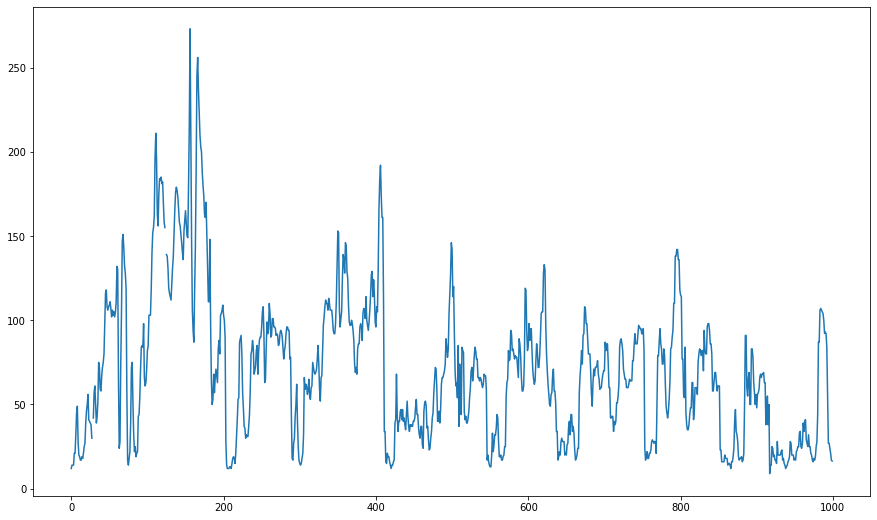

In [7]:
#our target has to be named 'y', we want to predict no2
df_a = df_a.rename(columns={'NO2':'y'})
#a sample of the readings
df_a[:1000]["y"].plot(figsize=(15,9))

In [8]:
#this dataset has almost 700 missing values, we don't have to fill these for this model
df_a[df_a["y"].isna()]

,No,year,month,day,hour,PM2.5,PM10,SO2,y,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station,ds
28,29,2013,3,2,4,3.0,6.0,7.0,NaN,400.0,59.0,-3.1,1032.7,-16.1,0.0,N,0.0,Nongzhanguan,2013-03-02 04:00:00
124,125,2013,3,6,4,153.0,175.0,87.0,NaN,1899.0,35.0,5.1,1009.5,-6.5,0.0,NE,1.0,Nongzhanguan,2013-03-06 04:00:00
1084,1085,2013,4,15,4,52.0,155.0,21.0,NaN,1000.0,5.0,5.5,1000.5,-1.7,0.0,ENE,0.6,Nongzhanguan,2013-04-15 04:00:00
1180,1181,2013,4,19,4,67.0,105.0,39.0,NaN,1100.0,30.0,7.1,1021.0,-4.7,0.0,SE,1.8,Nongzhanguan,2013-04-19 04:00:00
1276,1277,2013,4,23,4,85.0,101.0,15.0,NaN,800.0,46.0,10.0,1007.0,6.7,0.0,S,2.0,Nongzhanguan,2013-04-23 04:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34959,34960,2017,2,24,15,14.0,29.0,7.0,NaN,400.0,NaN,11.8,1018.8,-13.3,0.0,WSW,1.8,Nongzhanguan,2017-02-24 15:00:00
34986,34987,2017,2,25,18,NaN,NaN,NaN,NaN,NaN,NaN,11.4,1016.4,-12.1,0.0,NNW,2.6,Nongzhanguan,2017-02-25 18:00:00
35006,35007,2017,2,26,14,NaN,NaN,NaN,NaN,NaN,NaN,12.4,1018.9,-8.8,0.0,ESE,1.6,Nongzhanguan,2017-02-26 14:00:00
35026,35027,2017,2,27,10,NaN,NaN,NaN,NaN,NaN,NaN,6.8,1019.3,-5.2,0.0,E,1.9,Nongzhanguan,2017-02-27 10:00:00


## Fit a basic model
This model is very similar to classical prophet.

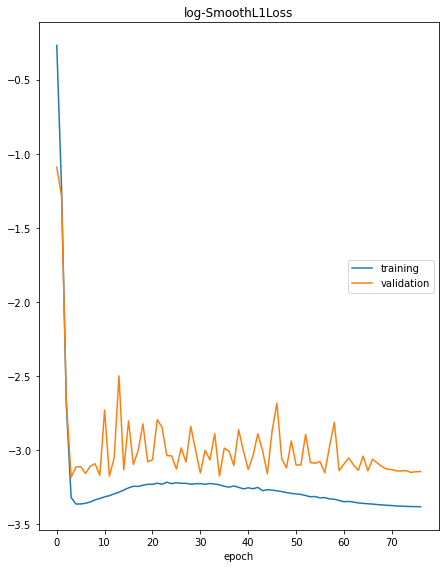

Epoch[77/77]: 100%|██████████| 77/77 [01:08<00:00,  1.12it/s, SmoothL1Loss=0.034, MAE=24.7, RMSE=32.1, RegLoss=0.0185, MAE_val=29.7, RMSE_val=36.3, SmoothL1Loss_val=0.0431]


In [9]:
#fit a model
m = NeuralProphet(
    trend_reg=1,
    learning_rate=0.03,
)
df_train, df_test = m.split_df(df_a[["ds","y"]], freq='H', valid_p = 1.0/12)

print(len(df_train), len(df_test))

metrics = m.fit(df_train, freq='H', validation_df=df_test, plot_live_loss=True)

In [10]:
metrics.tail(1)

,SmoothL1Loss,MAE,RMSE,RegLoss,SmoothL1Loss_val,MAE_val,RMSE_val
76,0.033977,24.696038,32.148162,0.018531,0.04309,29.716911,36.269704


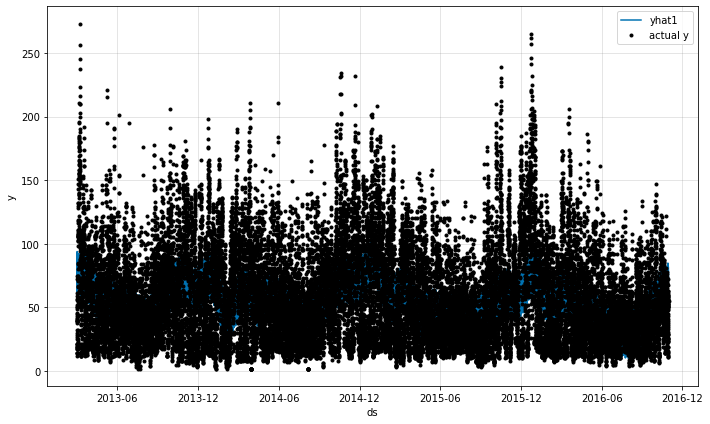

In [11]:
forecast = m.predict(df_train)
fig = m.plot(forecast)

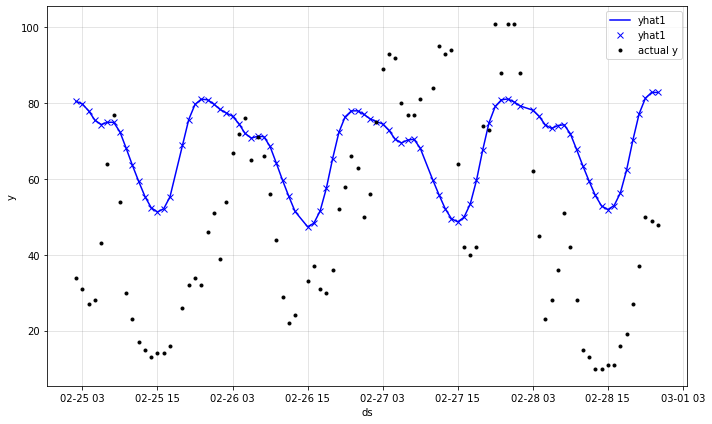

In [12]:
forecast = m.predict(df_test)
m = m.highlight_nth_step_ahead_of_each_forecast(1)
fig = m.plot(forecast[-3*30:])

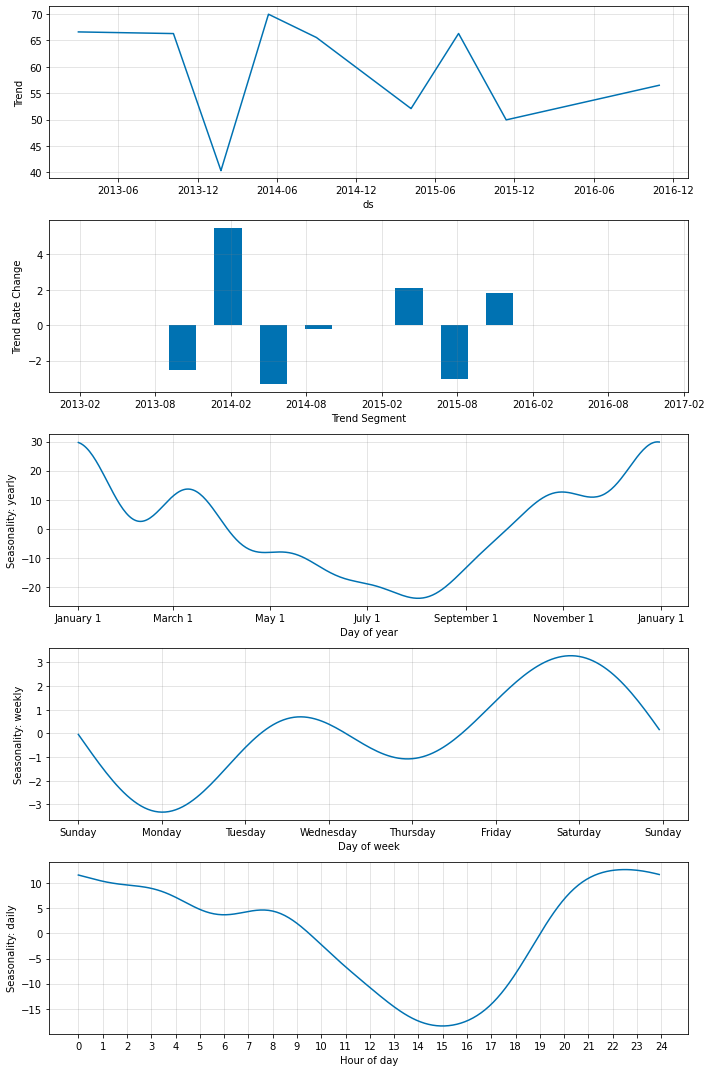

In [13]:
#various parameters fit to identify the trend
fig_param = m.plot_parameters()

## 1-step ahead forecast with Auto-Regression
We'll train a model that predicts one day's emissions at a time and uses the last 18 readings while doing so.

In [14]:
#model doesn't automatically impute many consecutive missing values
df_a["y"] = df_a['y'].fillna(df_a["y"].mean())

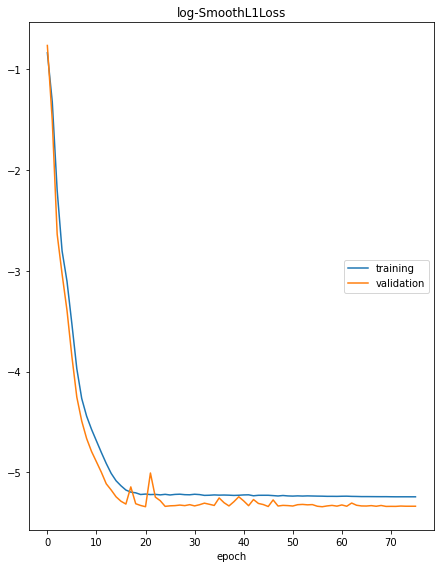

Epoch[76/76]: 100%|██████████| 76/76 [00:29<00:00,  2.55it/s, SmoothL1Loss=0.00529, MAE=7.96, RMSE=12.3, RegLoss=0.000191, MAE_val=7.48, RMSE_val=11.8, SmoothL1Loss_val=0.00482]


In [15]:
m = NeuralProphet(
    growth='off',
    yearly_seasonality=False,
    weekly_seasonality=False,
    daily_seasonality=False,
    n_lags=24,
    ar_sparsity=0.95,
    learning_rate = 0.003,
)

df_train, df_test = m.split_df(df_a[["ds","y"]], freq='H', valid_p = 1.0/12)

metrics = m.fit(df_train, freq='H', validation_df=df_test, plot_live_loss=True)

In [16]:
metrics.tail(1)

,SmoothL1Loss,MAE,RMSE,RegLoss,SmoothL1Loss_val,MAE_val,RMSE_val
75,0.005288,7.960161,12.338051,0.000191,0.004816,7.475399,11.822873


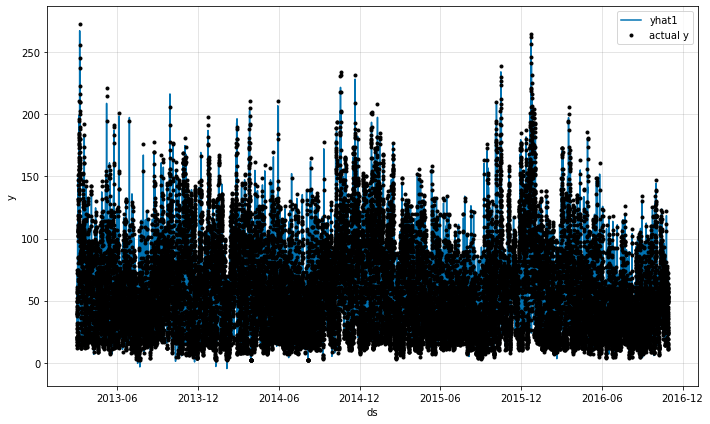

In [17]:
forecast = m.predict(df_train)
fig = m.plot(forecast)

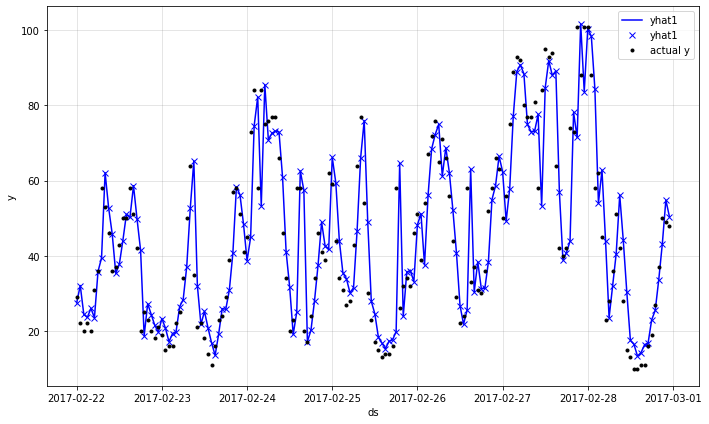

In [18]:
forecast = m.predict(df_test)
m = m.highlight_nth_step_ahead_of_each_forecast(1)
fig = m.plot(forecast[-7*24:])

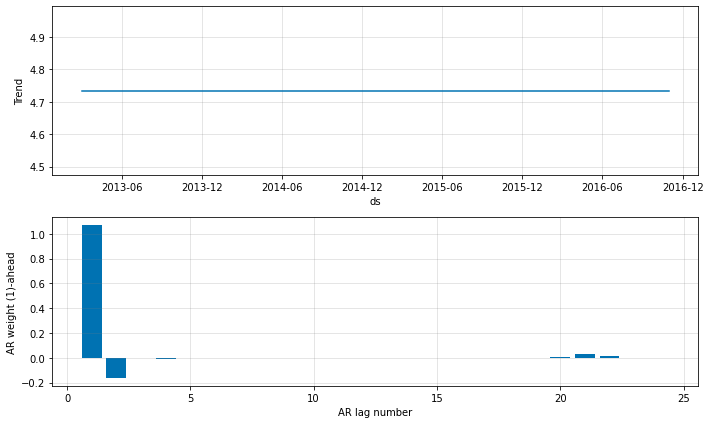

In [19]:
fig_param = m.plot_parameters()

## 1-Step ahead forecast with AR-Net: Using a Neural Network
Now we will include a neural network to generate predictions

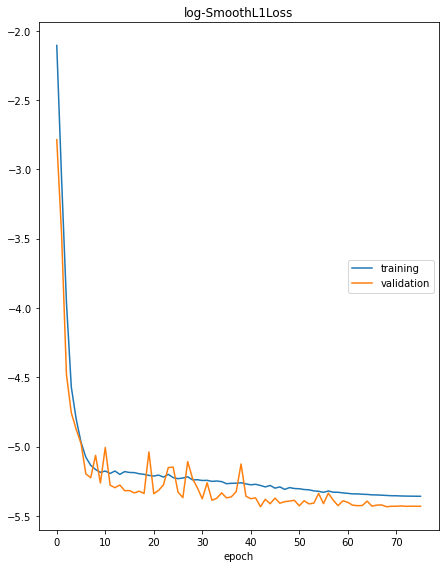

Epoch[76/76]: 100%|██████████| 76/76 [00:48<00:00,  1.58it/s, SmoothL1Loss=0.00471, MAE=7.65, RMSE=11.7, RegLoss=0, MAE_val=7.11, RMSE_val=11.3, SmoothL1Loss_val=0.00438]


In [20]:
m = NeuralProphet(
    growth='off',
    yearly_seasonality=False,
    weekly_seasonality=False,
    daily_seasonality=False,
    n_lags=24,
    num_hidden_layers=4,
    d_hidden=16,
    learning_rate=0.003,
)

metrics = m.fit(df_train, freq='H', validation_df=df_test, plot_live_loss=True)

In [21]:
metrics.tail(1)

,SmoothL1Loss,MAE,RMSE,RegLoss,SmoothL1Loss_val,MAE_val,RMSE_val
75,0.004706,7.652472,11.702181,0.0,0.004379,7.109471,11.28763


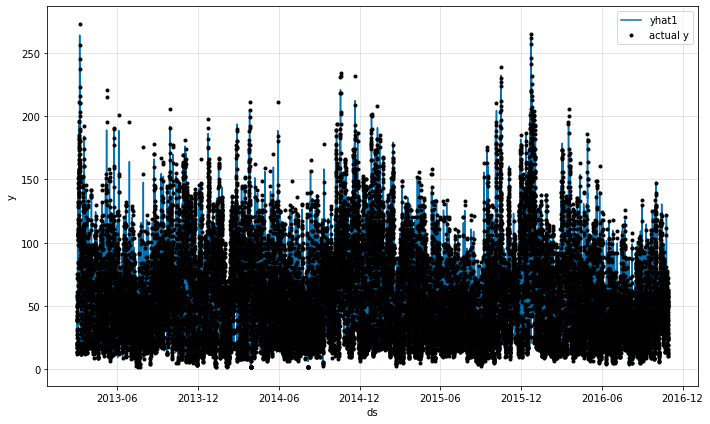

In [22]:
forecast = m.predict(df_train)
fig = m.plot(forecast)

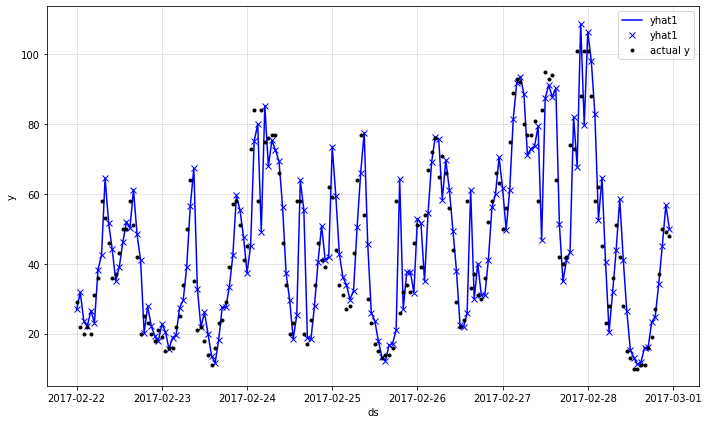

In [23]:
forecast = m.predict(df_test)
m = m.highlight_nth_step_ahead_of_each_forecast(1)
fig = m.plot(forecast[-7*24:])

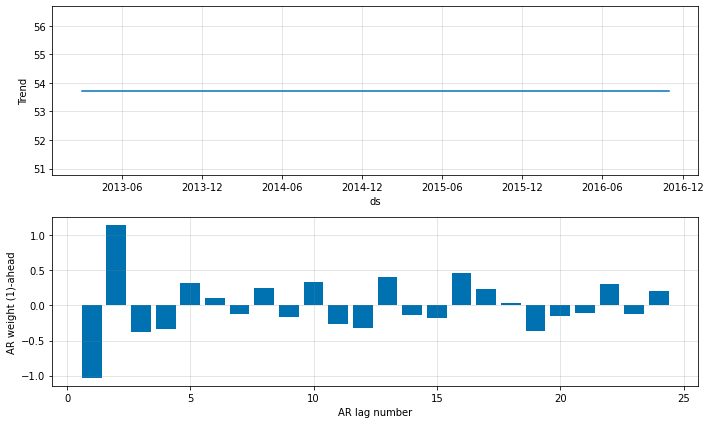

In [24]:
fig_comp = m.plot_parameters()

## 24-Step ahead using a Neural Net
We will use the last 3 days of readings to predict 24 hours of measurements at a time

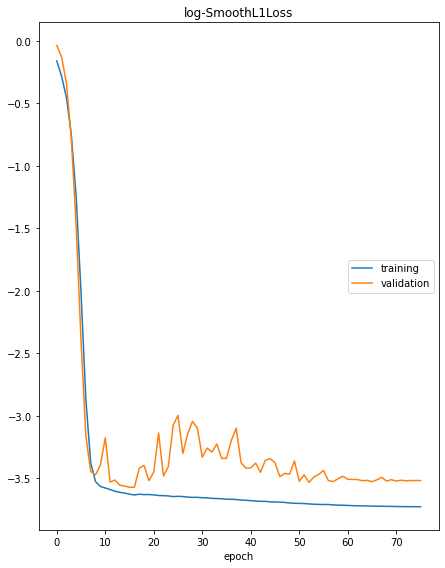

Epoch[76/76]: 100%|██████████| 76/76 [02:04<00:00,  1.64s/it, SmoothL1Loss=0.0241, MAE=20.2, RMSE=26.9, RegLoss=0.00375, MAE_val=23.2, RMSE_val=29.9, SmoothL1Loss_val=0.0297]


In [25]:
m = NeuralProphet(
    trend_reg=2,
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=True,
    n_lags=24*3,
    n_forecasts = 24,
    num_hidden_layers=4,
    d_hidden=16,
    learning_rate=0.003,
)

metrics = m.fit(df_train, freq='H', validation_df=df_test, plot_live_loss=True)

In [26]:
metrics.tail(1)

,SmoothL1Loss,MAE,RMSE,RegLoss,SmoothL1Loss_val,MAE_val,RMSE_val
75,0.024063,20.221852,26.927193,0.003747,0.029681,23.223076,29.906386


WARNING - (NP.plotting.plot) - Legend is available only for the ten first handles


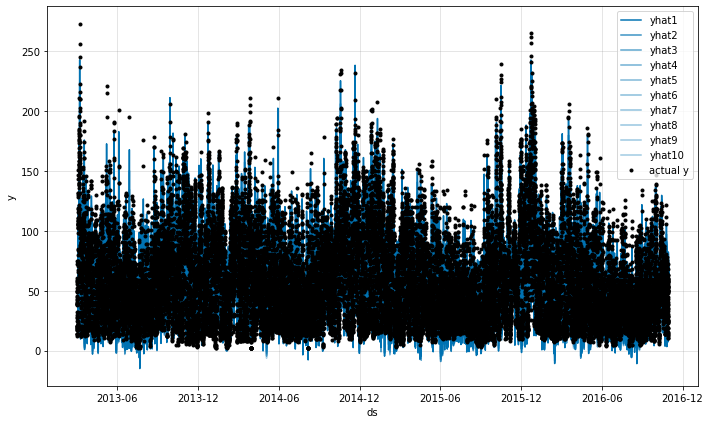

In [27]:
forecast = m.predict(df_train)
fig = m.plot(forecast)

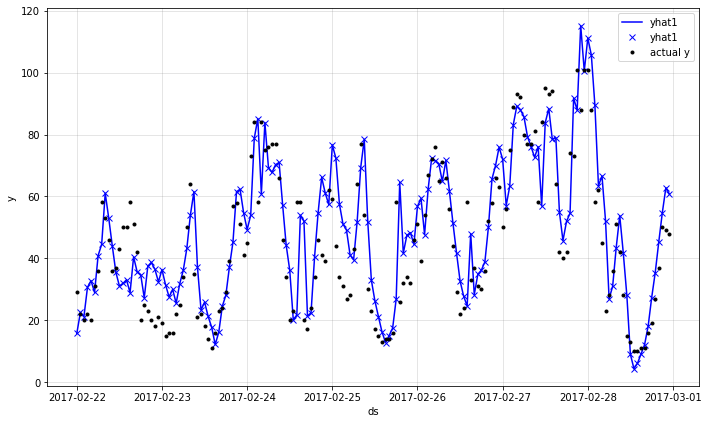

In [28]:
forecast = m.predict(df_test)
m = m.highlight_nth_step_ahead_of_each_forecast(1)
fig = m.plot(forecast[-7*24:])

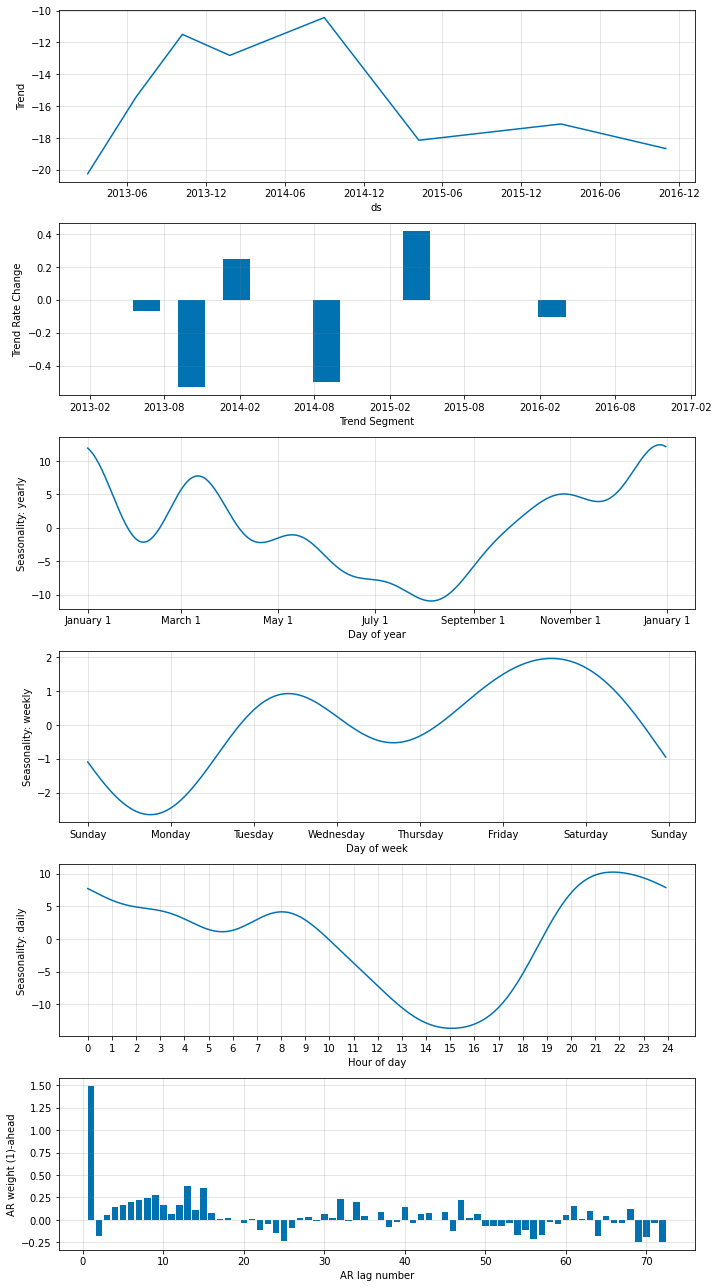

In [29]:
m = m.highlight_nth_step_ahead_of_each_forecast(1)
fig_param = m.plot_parameters()

## Making predictions
Future dataframe adds the number of future steps specified by the model (in this case 24).
Raw returns one array of predictions, rather than a staggered dataframe.

In [30]:
m.predict(m.make_future_dataframe(df_a[['ds','y']]),decompose=False,raw=True)

WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities


,ds,step0,step1,step2,step3,step4,step5,step6,step7,step8,...,step14,step15,step16,step17,step18,step19,step20,step21,step22,step23
0,2017-03-01,57.407513,57.935966,58.987038,59.4897,58.719715,57.342335,56.79134,57.649059,57.614529,...,36.840599,36.208477,37.296719,40.579727,46.479862,54.254223,60.699951,64.440285,65.639145,65.499939


## Additional Regressors
Providing additional data for the model to include in forecasting

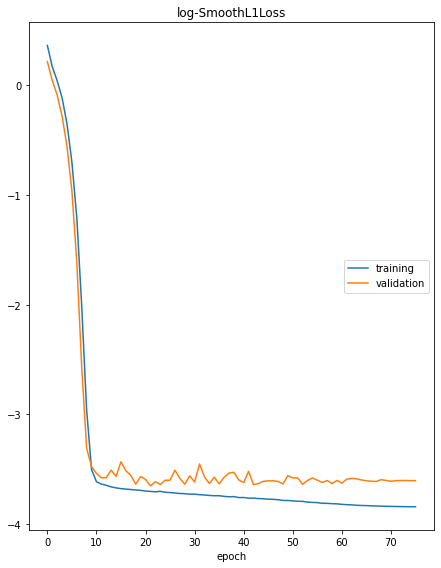

Epoch[76/76]: 100%|██████████| 76/76 [02:56<00:00,  2.32s/it, SmoothL1Loss=0.0214, MAE=19, RMSE=25.4, RegLoss=0, MAE_val=22, RMSE_val=28.6, SmoothL1Loss_val=0.0272]


In [31]:
m = NeuralProphet(
    growth='on',
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=True,
    n_lags=24*3,
    n_forecasts = 24,
    num_hidden_layers=4,
    d_hidden=16,
    learning_rate=0.003,
)
m = m.add_lagged_regressor('WSPM')
m = m.add_lagged_regressor('TEMP')

df_train_ar, df_test_ar = m.split_df(df_a[["ds","y","WSPM","TEMP"]], freq='H', valid_p = 1.0/12)

metrics = m.fit(df_train_ar, freq='H', validation_df=df_test_ar, plot_live_loss=True)

## Training all models
Prophet can't train using overlapping date ranges, so we can train a model for each city and its emissions and store them, loading the appropriate model for inferencing

In [32]:
stations = df['station'].unique()
df['ds'] = pd.to_datetime(df.rename(columns={'Date':'Day'})[['hour','day','month','year']])
df = df.rename(columns={'NO2':'y'})
df["y"] = df['y'].fillna(df["y"].mean())

if not os.path.exists('models'):
    os.makedirs('models')

m_s = NeuralProphet(
    trend_reg=2,
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=True,
    n_lags=24*3,
    n_forecasts = 24,
    num_hidden_layers=4,
    d_hidden=16,
    learning_rate=0.003,)

for s in stations:
    print(s)
    df_t = df[df['station']==s]
    df_train_t, df_test_t = m_s.split_df(df_t[["ds","y"]], freq='H', valid_p = 1.0/12)
    metrics = m_s.fit(df_train_t, freq='H', validation_df=df_test_t, plot_live_loss=False)
    with open('models/'+s+'.pkl', "wb") as f:
        pickle.dump(m_s, f)

INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 64
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 76


Aotizhongxin


Epoch[76/76]: 100%|██████████| 76/76 [02:01<00:00,  1.60s/it, SmoothL1Loss=0.0239, MAE=19.9, RMSE=26.6, RegLoss=0.00626, MAE_val=28.7, RMSE_val=36.8, SmoothL1Loss_val=0.0457] 
WARNING - (NP.forecaster.fit) - Model has already been fitted. Re-fitting will produce different results.


Changping


Epoch[76/76]: 100%|██████████| 76/76 [02:03<00:00,  1.62s/it, SmoothL1Loss=0.0147, MAE=15.5, RMSE=20.8, RegLoss=0.00177, MAE_val=24.5, RMSE_val=31.6, SmoothL1Loss_val=0.0339] 
WARNING - (NP.forecaster.fit) - Model has already been fitted. Re-fitting will produce different results.


Dingling


Epoch[76/76]: 100%|██████████| 76/76 [02:03<00:00,  1.63s/it, SmoothL1Loss=0.01, MAE=12.3, RMSE=17.2, RegLoss=0.000135, MAE_val=23.2, RMSE_val=31.7, SmoothL1Loss_val=0.0356]  
WARNING - (NP.forecaster.fit) - Model has already been fitted. Re-fitting will produce different results.


Dongsi


Epoch[76/76]: 100%|██████████| 76/76 [02:02<00:00,  1.61s/it, SmoothL1Loss=0.0195, MAE=18, RMSE=24.1, RegLoss=0.00101, MAE_val=25.8, RMSE_val=34.2, SmoothL1Loss_val=0.0397]   
WARNING - (NP.forecaster.fit) - Model has already been fitted. Re-fitting will produce different results.


Guanyuan


Epoch[76/76]: 100%|██████████| 76/76 [02:03<00:00,  1.63s/it, SmoothL1Loss=0.0202, MAE=18.4, RMSE=24.5, RegLoss=0.00112, MAE_val=25.6, RMSE_val=34.3, SmoothL1Loss_val=0.0401] 
WARNING - (NP.forecaster.fit) - Model has already been fitted. Re-fitting will produce different results.


Gucheng


Epoch[76/76]: 100%|██████████| 76/76 [02:00<00:00,  1.59s/it, SmoothL1Loss=0.0222, MAE=19.2, RMSE=25.7, RegLoss=0.00338, MAE_val=28.2, RMSE_val=38.9, SmoothL1Loss_val=0.0515] 
WARNING - (NP.forecaster.fit) - Model has already been fitted. Re-fitting will produce different results.


Huairou


Epoch[76/76]: 100%|██████████| 76/76 [02:00<00:00,  1.59s/it, SmoothL1Loss=0.0112, MAE=13.5, RMSE=18.2, RegLoss=0.000306, MAE_val=21.4, RMSE_val=28.9, SmoothL1Loss_val=0.0284]
WARNING - (NP.forecaster.fit) - Model has already been fitted. Re-fitting will produce different results.


Nongzhanguan


Epoch[76/76]: 100%|██████████| 76/76 [02:03<00:00,  1.62s/it, SmoothL1Loss=0.0234, MAE=19.8, RMSE=26.4, RegLoss=0.0017, MAE_val=23.6, RMSE_val=30.7, SmoothL1Loss_val=0.0317]  
WARNING - (NP.forecaster.fit) - Model has already been fitted. Re-fitting will produce different results.


Shunyi


Epoch[76/76]: 100%|██████████| 76/76 [02:00<00:00,  1.59s/it, SmoothL1Loss=0.0155, MAE=16.3, RMSE=21.5, RegLoss=0.000155, MAE_val=27.3, RMSE_val=35.7, SmoothL1Loss_val=0.0437]
WARNING - (NP.forecaster.fit) - Model has already been fitted. Re-fitting will produce different results.


Tiantan


Epoch[76/76]: 100%|██████████| 76/76 [02:02<00:00,  1.61s/it, SmoothL1Loss=0.0178, MAE=17.2, RMSE=22.9, RegLoss=0.00412, MAE_val=27.6, RMSE_val=37.4, SmoothL1Loss_val=0.0484] 
WARNING - (NP.forecaster.fit) - Model has already been fitted. Re-fitting will produce different results.


Wanliu


Epoch[76/76]: 100%|██████████| 76/76 [02:01<00:00,  1.60s/it, SmoothL1Loss=0.0222, MAE=19.3, RMSE=25.6, RegLoss=0.00234, MAE_val=26.9, RMSE_val=35.4, SmoothL1Loss_val=0.0424] 
WARNING - (NP.forecaster.fit) - Model has already been fitted. Re-fitting will produce different results.


Wanshouxigong


Epoch[76/76]: 100%|██████████| 76/76 [02:01<00:00,  1.59s/it, SmoothL1Loss=0.0205, MAE=18.5, RMSE=24.6, RegLoss=0.00195, MAE_val=29, RMSE_val=38.4, SmoothL1Loss_val=0.0508]   


In [33]:
!ls models

Aotizhongxin.pkl  Dongsi.pkl	Huairou.pkl	  Tiantan.pkl
Changping.pkl	  Guanyuan.pkl	Nongzhanguan.pkl  Wanliu.pkl
Dingling.pkl	  Gucheng.pkl	Shunyi.pkl	  Wanshouxigong.pkl


In [34]:
#loading one of the models
with open('models/Changping.pkl', "rb") as f:
    m_x = pickle.load(f)

In [35]:
#predicting
m_x.predict(m_x.make_future_dataframe(df[df['station']=='Changping'][['ds','y']]),decompose=False,raw=True)

WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities


,ds,step0,step1,step2,step3,step4,step5,step6,step7,step8,...,step14,step15,step16,step17,step18,step19,step20,step21,step22,step23
0,2017-03-01,29.592352,28.605656,28.597015,30.103474,31.596497,32.560276,35.343651,38.790005,41.470772,...,29.901701,30.170948,31.238285,33.979736,38.888416,44.176437,45.863529,44.990719,42.05006,41.281094
